# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [107]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


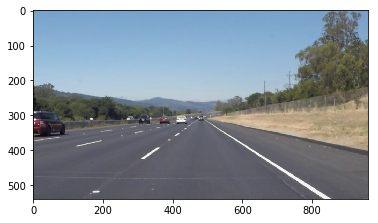

In [108]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [139]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    

    new_lines = []
    slopes = []
    slope_threshold = 0.5
    
    draw_left = True
    draw_right = True
    for line in lines: 
        x1,x2,y1,y2 = line[0]
        if x1 != x2:
            slope = (y2-y1)/(x2-x1)
        else:
            slope = 999.
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
            
    lines = new_lines
    left_lines = []
    right_lines = []
    x_mid = img.shape[1] /2
    for i,line in enumerate(lines):
        x1,y1,x2,y2 = line[0]
        if slopes[i] > 0 and x1 > x_mid and x2 > x_mid: 
            right_lines.append(line)
        elif slopes[i] < 0 and x1 < x_mid and x2 < x_mid:
            left_lines.append(line)
    x_right_lines = []
    y_right_lines = []
    
    for line in right_lines: 
        x1,y1,x2,y2 = line[0]
        x_right_lines.append(x1)
        x_right_lines.append(x2)
        
        y_right_lines.append(y1)
        y_right_lines.append(y2)
    if len(right_lines) > 0 :
        right_m, right_b = np.polyfit(x_right_lines, y_right_lines,1) # y = mx + b # right lines
    else:
        right_m = 1
        right_b = 1
        draw_right = False 
    # 
    x_left_lines = []
    y_left_lines = []
    for line in left_lines:
        x1,y1,x2,y2 = line[0]
        x_left_lines.append(x1)
        x_left_lines.append(x2)
        
        y_left_lines.append(y1)
        y_left_lines.append(y2)
    if len(left_lines)> 0:
        left_m, left_b = np.polyfit(x_left_lines, y_left_lines, 1) # y = mx + b # left lines
    else: 
        left_m = 1
        left_b = 1
        draw_left = False

    y1 = img.shape[0]
    y2 = img.shape[0] * (1 - trap_height)
    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m
    
    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m
    
    # Convert calculated end points from float to int
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    
    
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    print(lines[0])
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
    
   


    # Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [140]:
def filter_colors(image):
    color_select = np.copy(image)
    white_threshold = 200
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)

    # Filter yellow pixels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

    # Combine the two above images
    image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)
    return image2

In [141]:
# Global parameters

# Gaussian smoothing
kernel_size = 3

# Canny Edge Detector
low_threshold = 50
high_threshold = 150

# Region-of-interest vertices
# We want a trapezoid shape, with bottom edge at the bottom of the image
trap_bottom_width = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
trap_top_width = 0.07  # ditto for top edge of trapezoid
trap_height = 0.4  # height of the trapezoid expressed as percentage of image height

# Hough Transform
rho = 2 # distance resolution in pixels of the Hough grid
theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

In [142]:
def annotate_image(image_in):
    """ Given an image Numpy array, return the annotated image as a Numpy array """
    # Only keep white and yellow pixels in the image, all other pixels become black
    image = filter_colors(image_in)
    
    # Read in and grayscale the image
    #image = (image*255).astype('uint8')  # this step is unnecessary now
    gray = grayscale(image)

    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, kernel_size)

    # Apply Canny Edge Detector
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Create masked edges using trapezoid-shaped region-of-interest
    imshape = image.shape
    vertices = np.array([[\
        ((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw lane lines on the original image
    initial_image = image_in.astype('uint8')
    annotated_image = weighted_img(line_image, initial_image)
    
    return annotated_image

[[190 515 379 383]]


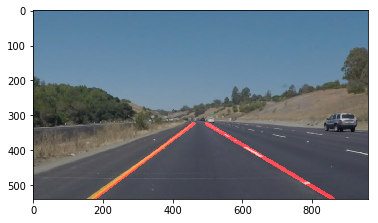

In [143]:
# Display an example image
annotated_image = annotate_image(mpimg.imread('./test_images/solidYellowCurve.jpg'))
plt.imshow(annotated_image)


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [144]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

[[536 339 897 539]]


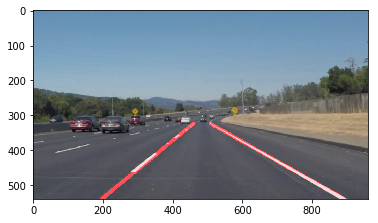

In [145]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

import os
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
image = mpimg.imread('./test_images/solidWhiteCurve.jpg')
"""
y_size = image.shape[0]
x_size = image.shape[1]
#[width*3/8, height*5/8], [width*5/8, height*5/8],
vertices = np.array([[(0,y_size),(x_size * 3/8, y_size * 3/8), (x_size * 5/8, y_size * 5/8), (x_size,y_size)]], dtype=np.int32)
gray_image = grayscale(image)
new_img = region_of_interest(gray_image, vertices)

new_img = gaussian_blur(new_img, kernel_size=5)

new_img = canny(new_img, low_threshold=50, high_threshold=150)

lines = hough_lines(new_img,rho=2, theta=np.pi/180, threshold=15, min_line_len=5, max_line_gap=1)

out_image = weighted_img(lines, image,α=0.8, β=1., λ=0.)

plt.imshow(out_image,cmap='gray')

"""
height = image.shape[0]
width = image.shape[1]
interest = np.array([[0, height], [width*3/8, height*5/8], [width*5/8, height*5/8], [width, height]], np.int32)

blur = gaussian_blur(image, 5)
hsv = cv2.cvtColor(blur, cv2.COLOR_RGB2HSV)
yellow = cv2.inRange(hsv, (20, 50, 50), (50, 255, 255))
white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))

trap_bottom_width = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
trap_top_width = 0.07  # ditto for top edge of trapezoid
trap_height = 0.4  # height of the trapezoid expressed as percentage of image height

gray = cv2.bitwise_or(yellow, white)
edges = canny(gray, 64, 192)
roi = region_of_interest(edges, [interest])
out = hough_lines(roi, 1, np.pi/180, 32, 2, 200)
result = weighted_img(image, out, 0.9, 0.9)
plt.imshow(result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [146]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

height 540
width 960
[[182 536 432 348]]


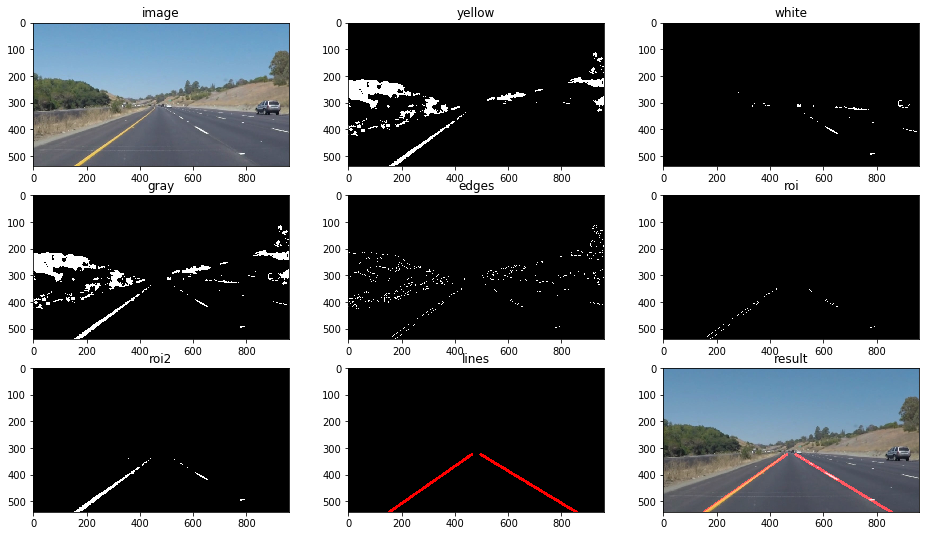

In [147]:
image = cv2.imread('test_images/solidYellowCurve.jpg')
# image = cv2.imread('test_images/solidWhiteCurve.jpg')

height = image.shape[0]
width = image.shape[1]
print("height",height)
print("width", width)
interest = np.array([[0, height], [width*3/8, height*5/8], [width*5/8, height*5/8], [width, height]], np.int32)

blur = gaussian_blur(image, 5)
hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
yellow = cv2.inRange(hsv, (20, 50, 50), (50, 255, 255))
white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
gray = cv2.bitwise_or(yellow, white)
edges = canny(gray, 64, 192)
roi = region_of_interest(edges, [interest])
roi2 = region_of_interest(gray, [interest])
out = hough_lines(roi, 1, np.pi/180, 32, 1, 200)
result = weighted_img(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), out, 0.9, 0.9)

plt.figure(figsize=[16, 9])

plt.subplot(3, 3, 1)
plt.title('image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(3, 3, 2)
plt.title('yellow')
plt.imshow(yellow, cmap='gray')
plt.subplot(3, 3, 3)
plt.title('white')
plt.imshow(white, cmap='gray')
plt.subplot(3, 3, 4)
plt.title('gray')
plt.imshow(gray, cmap='gray')
plt.subplot(3, 3, 5)
plt.title('edges')
plt.imshow(edges, cmap='gray')
plt.subplot(3, 3, 6)
plt.title('roi')
plt.imshow(roi, cmap='gray')
plt.subplot(3, 3, 7)
plt.title('roi2')
plt.imshow(roi2, cmap='gray')
plt.subplot(3, 3, 8)
plt.title('lines')
plt.imshow(out, cmap='gray')
plt.subplot(3, 3, 9)
plt.title('result')
plt.imshow(result)

In [148]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    height = image.shape[0]
    width = image.shape[1]
    interest = np.array([[0, height], [width*3/8, height*5/8], [width*5/8, height*5/8], [width, height]], np.int32)

    blur = gaussian_blur(image, 5)
    hsv = cv2.cvtColor(blur, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 50, 50), (50, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    edges = canny(gray, 64, 192)
    roi = region_of_interest(edges, [interest])
    out = hough_lines(roi, 1, np.pi/180, 32, 1, 200)
    result = weighted_img(image, out, 0.9, 0.9)
    return result

Let's try the one with the solid white lane on the right first ...

In [149]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[[538 339 868 538]]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 5/222 [00:00<00:04, 43.53it/s]

[[538 339 868 538]]
[[535 337 775 482]]
[[538 339 846 539]]
[[542 342 867 538]]
[[535 337 868 537]]
[[535 337 869 538]]
[[536 337 870 538]]
[[537 338 795 493]]
[[546 344 870 539]]

  5%|▍         | 10/222 [00:00<00:04, 45.02it/s]


[[613 393 841 536]]


  7%|▋         | 16/222 [00:00<00:04, 47.66it/s]

[[566 361 859 538]]
[[541 349 855 538]]
[[525 338 833 538]]
[[530 337 824 520]]
[[533 337 856 538]]
[[535 337 858 539]]
[[538 338 837 539]]
[[535 337 857 538]]
[[533 337 855 538]]
[[533 338 854 538]]
[[530 337 852 538]]


 10%|▉         | 22/222 [00:00<00:03, 50.09it/s]

[[529 337 853 539]]


 13%|█▎        | 28/222 [00:00<00:03, 50.97it/s]

[[553 351 853 538]]
[[533 338 852 537]]
[[532 337 854 538]]
[[532 337 853 538]]
[[532 337 854 538]]
[[532 337 854 538]]
[[532 337 854 538]]
[[620 391 856 538]]
[[541 342 856 539]]
[[534 337 857 539]]
[[543 343 857 539]]
[[555 355 836 538]]


 18%|█▊        | 40/222 [00:00<00:03, 53.61it/s]

[[573 368 834 538]]
[[559 359 832 537]]
[[530 338 781 494]]
[[598 385 833 538]]
[[551 349 853 538]]
[[531 337 854 539]]
[[532 337 854 538]]
[[532 337 852 537]]
[[536 340 760 491]]
[[532 337 854 538]]
[[532 337 847 534]]
[[532 337 854 539]]


 21%|██        | 46/222 [00:00<00:03, 52.61it/s]

[[532 337 832 539]]
[[533 338 831 539]]
[[531 337 850 536]]
[[531 337 830 539]]
[[532 338 831 539]]


 23%|██▎       | 52/222 [00:01<00:03, 43.35it/s]

[[534 339 831 539]]


 26%|██▌       | 57/222 [00:01<00:04, 40.80it/s]

[[549 349 831 539]]
[[544 346 831 539]]
[[533 337 831 538]]
[[531 337 844 533]]
[[530 337 849 537]]
[[537 345 703 456]]
[[528 337 847 537]]
[[525 337 771 502]]


 28%|██▊       | 62/222 [00:01<00:04, 36.78it/s]

[[524 337 824 539]]
[[524 337 823 538]]
[[524 337 822 538]]
[[647 412 842 538]]
[[525 338 821 538]]


 30%|██▉       | 66/222 [00:01<00:04, 33.42it/s]

[[526 339 821 538]]
[[528 339 823 538]]
[[526 337 824 538]]
[[525 337 824 539]]
[[524 337 822 538]]


 32%|███▏      | 70/222 [00:01<00:06, 24.36it/s]

[[525 337 822 538]]
[[525 337 822 538]]


 33%|███▎      | 73/222 [00:01<00:06, 23.56it/s]

[[527 339 821 538]]
[[524 337 818 536]]
[[525 338 819 537]]
[[534 341 710 455]]


 34%|███▍      | 76/222 [00:02<00:06, 24.07it/s]

[[537 343 839 539]]


 36%|███▌      | 79/222 [00:02<00:06, 22.77it/s]

[[528 337 838 538]]
[[529 338 836 538]]
[[529 338 760 489]]
[[526 338 813 539]]
[[531 342 812 539]]


 37%|███▋      | 83/222 [00:02<00:05, 24.70it/s]

[[531 342 811 539]]


 39%|███▊      | 86/222 [00:02<00:05, 23.72it/s]

[[525 337 810 537]]
[[543 351 810 538]]
[[531 342 810 538]]
[[541 349 810 538]]
[[531 342 810 538]]
[[587 383 809 539]]


 41%|████▏     | 92/222 [00:02<00:05, 24.00it/s]

[[539 344 711 460]]
[[572 372 808 538]]
[[538 343 811 527]]
[[540 344 828 539]]


 43%|████▎     | 96/222 [00:02<00:04, 26.43it/s]

[[539 346 670 441]]
[[530 337 829 539]]
[[537 342 713 470]]
[[533 338 831 539]]
[[532 337 766 507]]
[[533 337 812 539]]


 45%|████▍     | 99/222 [00:02<00:05, 24.59it/s]

[[534 337 750 494]]
[[534 337 812 539]]


 46%|████▌     | 102/222 [00:03<00:05, 23.09it/s]

[[575 365 831 538]]
[[560 355 831 538]]
[[605 392 813 538]]


 47%|████▋     | 105/222 [00:03<00:05, 23.34it/s]

[[575 365 750 483]]
[[536 337 835 539]]


 49%|████▊     | 108/222 [00:03<00:05, 22.48it/s]

[[581 372 817 538]]
[[590 378 818 538]]
[[543 341 820 527]]


 50%|█████     | 112/222 [00:03<00:04, 25.22it/s]

[[547 344 837 539]]
[[551 347 836 539]]
[[530 337 834 535]]
[[546 347 819 538]]


 52%|█████▏    | 116/222 [00:03<00:03, 26.66it/s]

[[580 365 780 499]]
[[535 337 822 538]]
[[536 337 823 538]]
[[544 342 825 539]]
[[549 345 834 530]]
[[573 360 844 536]]


 55%|█████▍    | 122/222 [00:03<00:03, 26.42it/s]

[[530 337 827 538]]
[[530 337 826 537]]
[[535 341 828 538]]
[[532 339 829 539]]
[[566 361 831 539]]
[[534 337 778 490]]


 56%|█████▋    | 125/222 [00:03<00:03, 25.24it/s]

[[534 337 853 537]]
[[537 338 854 536]]


 59%|█████▉    | 131/222 [00:04<00:03, 24.44it/s]

[[535 337 857 538]]
[[535 337 858 539]]
[[555 354 837 538]]
[[556 355 838 539]]
[[534 340 833 535]]
[[534 337 858 539]]
[[537 338 859 539]]

 60%|██████    | 134/222 [00:04<00:03, 23.87it/s]


[[541 339 860 539]]
[[540 337 862 538]]
[[592 375 842 538]]


 64%|██████▍   | 142/222 [00:04<00:02, 28.57it/s]

[[592 375 844 539]]
[[552 346 741 464]]
[[536 337 806 505]]
[[649 415 839 539]]
[[556 351 777 489]]
[[534 337 829 521]]
[[535 337 858 539]]
[[535 337 858 538]]

 68%|██████▊   | 150/222 [00:04<00:02, 31.75it/s]


[[575 365 841 538]]
[[568 359 844 539]]
[[535 337 836 532]]
[[537 338 869 538]]
[[538 338 731 463]]
[[542 341 870 538]]
[[534 337 868 538]]


 69%|██████▉   | 154/222 [00:04<00:02, 31.08it/s]

[[541 341 847 539]]
[[536 337 848 539]]
[[538 337 848 538]]
[[539 337 849 539]]
[[539 337 850 539]]


 71%|███████   | 158/222 [00:05<00:02, 30.45it/s]

[[543 339 775 489]]
[[549 342 874 537]]

 73%|███████▎  | 162/222 [00:05<00:01, 32.07it/s]


[[579 359 878 538]]
[[626 386 881 539]]
[[539 337 861 539]]
[[539 337 793 484]]
[[542 339 814 496]]
[[598 371 849 516]]


 75%|███████▍  | 166/222 [00:05<00:01, 33.36it/s]

[[602 374 883 536]]
[[539 342 864 538]]


 77%|███████▋  | 170/222 [00:05<00:01, 34.24it/s]

[[546 346 863 537]]
[[552 350 862 537]]
[[535 337 884 538]]
[[554 351 859 535]]
[[537 338 883 538]]
[[564 357 861 536]]


 78%|███████▊  | 174/222 [00:05<00:01, 34.60it/s]

[[571 361 859 535]]
[[588 372 865 539]]


 80%|████████  | 178/222 [00:05<00:01, 35.44it/s]

[[590 373 864 538]]
[[538 340 884 539]]
[[605 382 864 538]]
[[536 337 885 538]]
[[538 337 887 538]]
[[537 337 698 437]]
[[614 385 869 539]]

 82%|████████▏ | 183/222 [00:05<00:01, 36.44it/s]


[[572 355 889 538]]


 84%|████████▍ | 187/222 [00:05<00:00, 36.33it/s]

[[541 338 889 538]]
[[542 339 887 538]]
[[601 372 790 482]]
[[539 337 840 511]]
[[541 337 890 538]]
[[542 338 877 539]]
[[548 339 815 499]]


 86%|████████▌ | 191/222 [00:06<00:00, 36.78it/s]

[[645 398 827 504]]


 88%|████████▊ | 195/222 [00:06<00:00, 36.71it/s]

[[678 419 878 535]]
[[556 349 747 463]]
[[538 338 872 539]]
[[562 354 869 538]]
[[581 363 885 538]]
[[537 339 868 538]]
[[649 400 889 538]]


 90%|████████▉ | 199/222 [00:06<00:00, 36.03it/s]

[[538 338 871 538]]


 91%|█████████▏| 203/222 [00:06<00:00, 34.22it/s]

[[537 339 869 538]]
[[710 434 892 539]]
[[539 340 887 533]]
[[536 338 892 536]]
[[662 406 897 537]]
[[540 337 729 442]]
[[541 337 835 513]]
[[541 337 849 508]]

 95%|█████████▌| 211/222 [00:06<00:00, 35.58it/s]


[[542 337 866 517]]
[[560 347 905 538]]
[[544 339 905 539]]
[[539 338 884 538]]
[[537 339 883 539]]
[[543 340 902 539]]


 97%|█████████▋| 215/222 [00:06<00:00, 35.87it/s]

[[541 340 899 538]]
[[537 338 898 538]]


100%|█████████▉| 221/222 [00:06<00:00, 32.29it/s]

[[537 339 897 538]]
[[539 340 896 538]]
[[539 340 896 538]]
[[574 363 874 537]]
[[538 339 894 537]]
[[595 375 874 537]]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.89 s, sys: 1.16 s, total: 6.05 s
Wall time: 7.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [150]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[[261 680 497 521]]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 3/251 [00:00<00:09, 25.37it/s]

[[261 680 497 521]]
[[258 683 489 527]]
[[257 684 491 527]]
[[291 682 574 477]]
[[314 645 561 485]]


  2%|▏         | 6/251 [00:00<00:09, 26.02it/s]

[[355 620 566 483]]


  4%|▎         | 9/251 [00:00<00:09, 25.11it/s]

[[263 684 533 502]]
[[266 683 553 490]]
[[315 672 580 473]]
[[272 684 541 496]]
[[302 685 582 474]]
[[299 686 587 469]]

  6%|▌         | 15/251 [00:00<00:08, 26.37it/s]


[[277 681 497 527]]
[[275 682 533 502]]
[[276 683 554 488]]
[[299 686 568 483]]
[[300 685 568 483]]
[[360 623 554 487]]
[[307 682 562 483]]


  9%|▉         | 22/251 [00:00<00:08, 27.30it/s]

[[278 683 453 556]]
[[278 681 555 487]]
[[276 681 549 490]]
[[275 682 545 493]]
[[277 681 551 489]]
[[274 683 557 485]]


 11%|█         | 28/251 [00:01<00:08, 25.80it/s]

[[290 671 551 488]]
[[276 682 490 527]]
[[300 685 554 487]]
[[276 678 535 497]]
[[272 681 519 508]]
[[269 683 526 503]]


 14%|█▎        | 34/251 [00:01<00:08, 26.19it/s]

[[267 683 501 520]]
[[265 684 487 528]]
[[267 681 465 542]]
[[265 682 447 555]]
[[287 686 537 498]]
[[261 682 516 510]]


 16%|█▌        | 40/251 [00:01<00:09, 22.85it/s]

[[257 684 511 513]]
[[257 684 520 507]]
[[285 685 568 480]]
[[287 685 567 482]]


 17%|█▋        | 43/251 [00:01<00:09, 21.26it/s]

[[266 678 484 531]]
[[280 686 582 475]]
[[279 687 584 474]]
[[287 664 572 479]]


 18%|█▊        | 46/251 [00:01<00:09, 22.39it/s]

[[284 687 606 462]]
[[266 683 539 499]]


 20%|█▉        | 49/251 [00:02<00:09, 21.77it/s]

[[300 680 591 469]]
[[298 682 588 471]]
[[293 685 591 469]]
[[315 673 574 478]]


 21%|██        | 52/251 [00:02<00:10, 19.48it/s]

[[292 686 587 472]]
[[271 681 564 484]]
[[271 683 526 505]]
[[345 650 567 483]]


 24%|██▎       | 59/251 [00:02<00:12, 15.59it/s]

[[305 680 569 481]]
[[273 683 537 498]]
[[280 678 519 511]]
[[299 684 569 481]]


 25%|██▌       | 63/251 [00:02<00:12, 15.54it/s]

[[279 677 498 524]]
[[296 685 565 483]]
[[305 677 557 487]]
[[268 683 455 552]]


 26%|██▌       | 65/251 [00:03<00:12, 14.79it/s]

[[288 686 582 473]]
[[289 685 590 467]]
[[266 683 535 502]]


 27%|██▋       | 69/251 [00:03<00:12, 14.75it/s]

[[278 674 490 531]]
[[267 684 552 492]]
[[288 670 559 487]]
[[275 683 492 531]]


 29%|██▉       | 74/251 [00:03<00:10, 16.84it/s]

[[276 684 530 507]]
[[306 684 585 474]]
[[282 683 526 512]]
[[285 682 513 517]]
[[311 684 593 472]]

 30%|███       | 76/251 [00:03<00:10, 17.42it/s]


[[312 685 590 476]]
[[348 639 545 501]]
[[314 685 601 469]]


 32%|███▏      | 81/251 [00:04<00:09, 17.79it/s]

[[322 682 576 484]]
[[293 682 520 517]]
[[294 683 531 511]]
[[295 682 522 517]]


 34%|███▍      | 86/251 [00:04<00:08, 18.47it/s]

[[322 684 606 462]]
[[297 682 597 464]]
[[299 681 593 467]]
[[301 681 595 467]]


 36%|███▌      | 90/251 [00:04<00:08, 18.71it/s]

[[342 673 596 467]]
[[349 646 600 470]]
[[339 678 607 461]]
[[310 682 595 468]]
[[333 683 597 469]]


 37%|███▋      | 94/251 [00:04<00:08, 18.97it/s]

[[310 682 592 469]]
[[759 477 963 590]]
[[ 766  480 1073  650]]
[[ 941  576 1111  670]]


 39%|███▉      | 98/251 [00:04<00:09, 16.39it/s]

[[ 759  480 1115  670]]
[[343 678 579 473]]
[[332 685 589 470]]
[[337 680 570 478]]


 41%|████      | 102/251 [00:05<00:09, 16.13it/s]

[[350 661 576 478]]
[[320 685 576 478]]
[[319 683 576 475]]
[[314 684 520 523]]


 42%|████▏     | 106/251 [00:05<00:09, 15.05it/s]

[[302 673 574 475]]
[[298 685 543 494]]
[[346 668 554 487]]


 44%|████▍     | 110/251 [00:05<00:09, 15.43it/s]

[[295 684 534 497]]
[[ 930  582 1089  663]]
[[311 684 531 500]]
[[308 684 519 507]]


 45%|████▍     | 112/251 [00:05<00:09, 14.28it/s]

[[285 686 566 475]]
[[275 685 570 471]]
[[270 685 566 470]]


 45%|████▌     | 114/251 [00:06<00:10, 13.50it/s]

[[265 685 561 470]]
[[267 683 551 477]]


 47%|████▋     | 118/251 [00:06<00:09, 13.42it/s]

[[270 690 531 501]]
[[273 687 562 477]]
[[248 685 577 471]]
[[271 686 581 469]]


 49%|████▊     | 122/251 [00:06<00:08, 15.12it/s]

[[269 683 574 470]]
[[241 684 542 489]]
[[ 903  573 1044  658]]
[[237 676 580 462]]


 50%|█████     | 126/251 [00:06<00:07, 16.14it/s]

[[235 677 560 474]]
[[247 686 576 464]]
[[227 686 523 494]]
[[228 685 501 508]]


 52%|█████▏    | 130/251 [00:07<00:07, 15.43it/s]

[[231 684 564 468]]
[[247 687 596 452]]
[[246 686 582 460]]


 53%|█████▎    | 132/251 [00:07<00:09, 13.22it/s]

[[250 686 579 464]]
[[225 683 571 467]]


 53%|█████▎    | 134/251 [00:07<00:09, 12.62it/s]

[[219 683 565 467]]
[[215 684 557 471]]
[[215 683 555 471]]


 55%|█████▍    | 138/251 [00:07<00:09, 12.51it/s]

[[216 685 566 466]]
[[217 683 482 518]]
[[217 685 535 487]]


 56%|█████▌    | 140/251 [00:08<00:09, 12.28it/s]

[[235 688 560 477]]
[[215 686 473 525]]
[[231 672 536 489]]
[[240 685 521 496]]


 57%|█████▋    | 144/251 [00:08<00:08, 13.22it/s]

[[210 682 534 488]]
[[234 686 547 483]]
[[216 682 511 504]]
[[241 686 531 498]]

 59%|█████▉    | 148/251 [00:08<00:08, 12.82it/s]


[[217 685 518 504]]
[[223 682 576 470]]


 60%|█████▉    | 150/251 [00:08<00:07, 12.69it/s]

[[238 686 581 472]]
[[224 684 582 469]]
[[242 670 575 477]]


 61%|██████▏   | 154/251 [00:09<00:07, 13.35it/s]

[[248 685 577 472]]
[[221 683 565 477]]
[[235 685 561 481]]


 63%|██████▎   | 158/251 [00:09<00:06, 14.44it/s]

[[251 678 569 472]]
[[226 680 611 457]]
[[300 638 594 462]]
[[239 680 532 490]]


 64%|██████▎   | 160/251 [00:09<00:06, 13.65it/s]

[[238 681 525 495]]
[[222 679 558 477]]
[[214 686 591 460]]


 65%|██████▌   | 164/251 [00:09<00:06, 13.10it/s]

[[217 679 594 461]]
[[224 675 596 460]]
[[221 686 550 489]]


 66%|██████▌   | 166/251 [00:09<00:06, 13.03it/s]

[[230 671 492 520]]
[[232 689 540 497]]
[[216 684 544 495]]
[[221 683 545 496]]

 69%|██████▊   | 172/251 [00:10<00:05, 14.06it/s]


[[305 638 535 505]]
[[237 684 471 544]]
[[247 684 578 485]]
[[275 672 576 484]]


 69%|██████▉   | 174/251 [00:10<00:05, 13.92it/s]

[[257 685 561 488]]
[[274 674 557 490]]
[[280 685 591 468]]


 71%|███████   | 178/251 [00:10<00:05, 12.30it/s]

[[277 670 490 527]]
[[280 685 593 466]]
[[260 684 502 521]]


 72%|███████▏  | 180/251 [00:11<00:05, 12.62it/s]

[[341 629 556 489]]
[[262 685 520 511]]
[[267 680 503 521]]
[[287 686 571 480]]

 73%|███████▎  | 184/251 [00:11<00:05, 13.17it/s]


[[294 682 584 472]]
[[295 682 573 480]]
[[294 684 582 475]]


 75%|███████▍  | 188/251 [00:11<00:05, 12.41it/s]

[[296 683 590 470]]
[[276 681 572 482]]
[[280 679 563 489]]


 76%|███████▌  | 190/251 [00:11<00:04, 12.73it/s]

[[316 677 568 487]]
[[307 685 567 489]]
[[284 682 556 491]]


 77%|███████▋  | 194/251 [00:12<00:04, 13.83it/s]

[[309 684 606 461]]
[[287 684 521 514]]
[[313 683 564 487]]


 78%|███████▊  | 196/251 [00:12<00:04, 13.49it/s]

[[288 683 546 496]]
[[317 680 563 488]]
[[314 682 568 484]]
[[313 684 563 489]]


 80%|███████▉  | 200/251 [00:12<00:03, 13.25it/s]

[[308 685 606 460]]
[[329 653 570 484]]
[[314 684 576 480]]


 81%|████████▏ | 204/251 [00:12<00:03, 14.23it/s]

[[289 682 519 515]]
[[289 684 551 494]]
[[290 682 546 496]]
[[292 683 551 495]]


 82%|████████▏ | 206/251 [00:12<00:03, 14.75it/s]

[[357 655 569 484]]
[[296 684 517 517]]
[[298 680 543 502]]


 84%|████████▎ | 210/251 [00:13<00:03, 13.01it/s]

[[330 678 580 476]]
[[298 683 440 576]]
[[318 685 586 476]]
[[319 665 580 475]]

 85%|████████▌ | 214/251 [00:13<00:02, 13.81it/s]


[[386 617 581 475]]
[[ 948  591 1093  675]]
[[301 683 567 483]]
[[303 684 563 488]]

 87%|████████▋ | 218/251 [00:13<00:02, 14.31it/s]


[[305 682 563 488]]
[[334 682 604 464]]
[[307 684 537 505]]
[[349 673 594 468]]

 88%|████████▊ | 222/251 [00:14<00:02, 14.24it/s]


[[311 682 537 506]]
[[344 676 607 456]]
[[310 682 537 505]]


 90%|█████████ | 227/251 [00:14<00:01, 15.04it/s]

[[308 683 525 513]]
[[331 683 583 472]]
[[308 682 511 524]]
[[310 681 506 528]]


 92%|█████████▏| 231/251 [00:14<00:01, 15.74it/s]

[[338 680 578 479]]
[[307 682 497 534]]
[[305 682 501 529]]
[[301 682 545 498]]


 94%|█████████▎| 235/251 [00:14<00:00, 17.07it/s]

[[324 684 603 458]]
[[324 682 587 469]]
[[297 683 562 484]]
[[324 682 580 475]]
[[333 676 590 468]]

 95%|█████████▌| 239/251 [00:15<00:00, 16.76it/s]


[[297 683 581 469]]
[[298 681 557 486]]
[[299 681 553 490]]
[[298 682 544 497]]


 97%|█████████▋| 243/251 [00:15<00:00, 14.30it/s]

[[298 682 547 495]]
[[298 683 543 499]]
[[323 683 586 470]]


 98%|█████████▊| 245/251 [00:15<00:00, 14.43it/s]

[[320 684 586 469]]
[[321 683 587 468]]
[[318 684 601 455]]


 99%|█████████▉| 249/251 [00:15<00:00, 14.75it/s]

[[ 915  580 1081  676]]
[[294 682 477 544]]
[[333 650 508 523]]
[[314 685 594 467]]


100%|██████████| 251/251 [00:15<00:00, 15.17it/s]


[[288 682 518 515]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 9.42 s, sys: 2.62 s, total: 12 s
Wall time: 17.5 s


In [151]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))